In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, SeparableConv2D

# %matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
## Print out some system information
import subprocess

print('Linux kernel version:')
print('$ uname -r')
result = subprocess.run(['uname', '-r'], stdout=subprocess.PIPE)
print(result.stdout.decode('utf-8'))

print('Linux release:')
print('$ lsb_release -a')
result = subprocess.run(['lsb_release', '-a'], stdout=subprocess.PIPE)
print(result.stdout.decode('utf-8'))

print('Tensorflow python module version')
print(tf.__version__)
print('')

print('Edge TPU python module version:')
import edgetpu
print(edgetpu.__version__)
print('')

print('Edge TPU compiler version:')
result = subprocess.run(['edgetpu_compiler', '--version'], stdout=subprocess.PIPE)
print(result.stdout.decode('utf-8'))

print('Edge TPU runtime version:')
import edgetpu.basic.edgetpu_utils
print(edgetpu.basic.edgetpu_utils.GetRuntimeVersion())
print('')

print('Paths of available Edge TPU devices, if any:')
print(edgetpu.basic.edgetpu_utils.ListEdgeTpuPaths(edgetpu.basic.edgetpu_utils.EDGE_TPU_STATE_NONE))

Linux kernel version:
$ uname -r
4.4.0-96-generic

Linux release:
$ lsb_release -a
Distributor ID:	Ubuntu
Description:	Ubuntu 16.04.6 LTS
Release:	16.04
Codename:	xenial

Tensorflow python module version
2.0.0-rc0

Edge TPU python module version:
2.11.1

Edge TPU compiler version:
Edge TPU Compiler version 2.0.258810407

Edge TPU runtime version:
BuildLabel(N/A), RuntimeVersion(12)

Paths of available Edge TPU devices, if any:
('/sys/bus/usb/devices/4-5',)


In [3]:
## Build a very simple model
image_shape = (16, 16, 3)

def representative_dataset_gen():
    num_calibration_images = 10  #  Slow. About 1 second per calibration image.
    for i in range(num_calibration_images):
        image = tf.random.normal([1] + list(image_shape))
        yield [image]

x = Input(shape=image_shape)
y = MaxPooling2D(pool_size=(4, 4))(x)
# y = Conv2D(1, (3, 3), padding='same')(x)
# y = SeparableConv2D(3, (3, 3), padding='same')(x)
model = Model(inputs=x, outputs=y)

In [4]:
## Convert to tensorflow lite model and save...
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_dataset_gen)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8] # For EdgeTPU, no float ops allowed

tflite_model = converter.convert()
open('model.tflite', 'wb').write(tflite_model)

896

In [5]:
##================================================================================================
## Set variable below and comment out lines in cell below if not using Edge TPU model and hardware
##================================================================================================
# True:  Use EdgeTPU model and process on the Edge TPU (assumes one is available)
# False: Use TFLite model and process on CPU
use_edgetpu = True

In [6]:
%%bash
## Compile model for edge TPU
edgetpu_compiler --min_runtime_version 10 --show_operations 'model.tflite'

Edge TPU Compiler version 2.0.258810407

Model compiled successfully in 0 ms.

Input model: model.tflite
Input size: 896.00B
Output model: model_edgetpu.tflite
Output size: 792.00B
On-chip memory available for caching model parameters: 0.00B
On-chip memory used for caching model parameters: 0.00B
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 0
Total number of operations: 3
Operation log: model_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 0
Number of operations that will run on CPU: 3

Operator                       Count      Status

DEQUANTIZE                     1          Operation is working on an unsupported data type
MAX_POOL_2D  

INFO: Initialized TensorFlow Lite runtime.


In [7]:
## Load TFLite model and allocate tensors.
if use_edgetpu:
    # from tflite_runtime.interpreter import load_delegate  # if using tflite_runtime package
    from tensorflow.lite.python.interpreter import load_delegate  # if using full TensorFlow package
    interpreter = tf.lite.Interpreter(model_path='model_edgetpu.tflite',
                                      experimental_delegates=[load_delegate('libedgetpu.so.1.0')])
else:
    interpreter = tf.lite.Interpreter(model_path='model.tflite')

interpreter.allocate_tensors()

# Get input and output tensors details.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

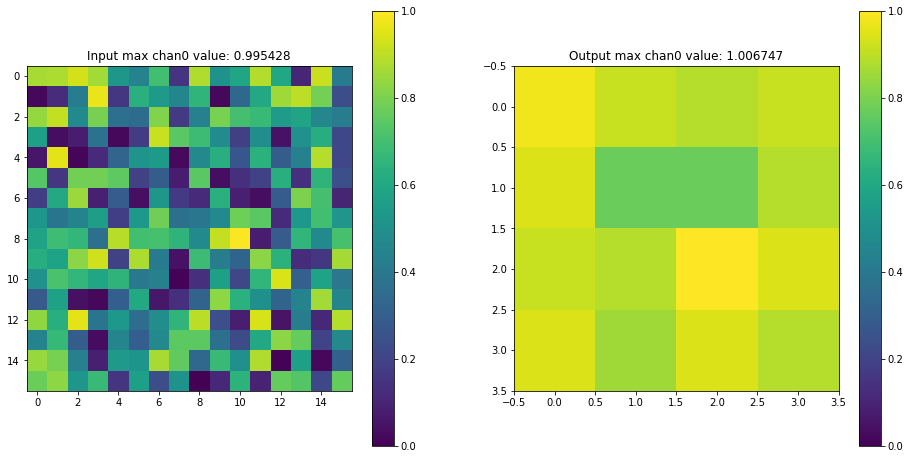

In [8]:
## Put some random data through the model and show results
# Create an image (batch size of 1)
image = tf.random.uniform([1] + list(image_shape))

# Set input tensor and invoke model
interpreter.set_tensor(input_details[0]['index'], image)
interpreter.invoke()   # Can be slow if running on CPU

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
model_output = interpreter.get_tensor(output_details[0]['index'])

# Plot results for first channel of input and output
in_chan0 = image[0, :, :, 0]
out_chan0 = model_output[0, :, :, 0]
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
plt.imshow(in_chan0, aspect='equal')
plt.title('Input max chan0 value: %f' % (tf.reduce_max(in_chan0)))
plt.clim([0,1])
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(out_chan0, aspect='equal')
plt.title('Output max chan0 value: %f' % (tf.reduce_max(out_chan0)))
plt.clim([0,1])
plt.colorbar()